In [4]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('.')

attributes = dir(writer)
print(attributes)
print(writer.get_logdir())
print(writer.log_dir)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__firstlineno__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__static_attributes__', '__str__', '__subclasshook__', '__weakref__', '_encode', '_get_file_writer', 'add_audio', 'add_custom_scalars', 'add_custom_scalars_marginchart', 'add_custom_scalars_multilinechart', 'add_embedding', 'add_figure', 'add_graph', 'add_histogram', 'add_histogram_raw', 'add_hparams', 'add_image', 'add_image_with_boxes', 'add_images', 'add_mesh', 'add_onnx_graph', 'add_pr_curve', 'add_pr_curve_raw', 'add_scalar', 'add_scalars', 'add_tensor', 'add_text', 'add_video', 'all_writers', 'close', 'default_bins', 'file_writer', 'filename_suffix', 'flush', 'flush_secs', 'get_logdir', 'log_dir', 'max_queue', 'purge_step']
.


(5, 30, 12, 128, 128)
Are the slices equal? True


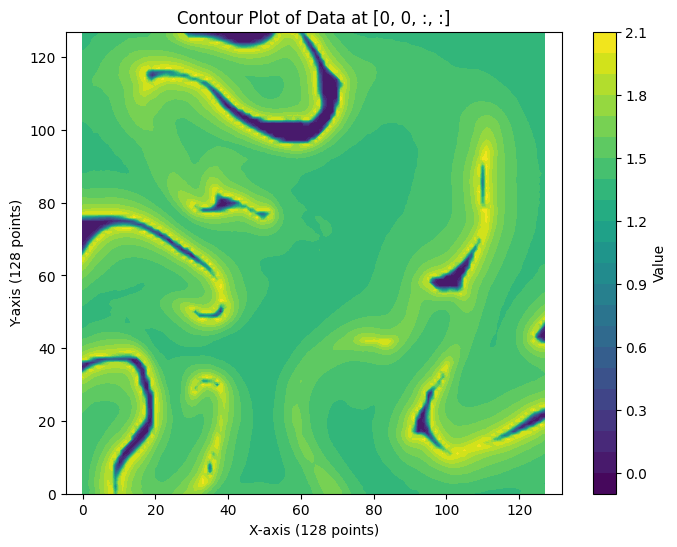

In [15]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('/mnt/d/u_deepflame_agent/hit-best/bestModelResults/CNextv2-seed-0-7_31_3_24_19_52157/states.npy')
print(data.shape)

data1 = np.load('/mnt/d/u_deepflame_agent/hit-best/bestModelResults/CNextv2-seed-0-7_31_3_24_19_52157/final_states.npy')

slice_data = data[0, 29, 0, :, :]
slice_data1 = data1[0, 0, :, :]
are_equal = np.array_equal(slice_data, slice_data1)
print(f"Are the slices equal? {are_equal}")

# Create a contour plot
plt.figure(figsize=(8, 6))
plt.contourf(slice_data, levels=20, cmap='viridis')
plt.colorbar(label='Value')
plt.title('Contour Plot of Data at [0, 0, :, :]')
plt.xlabel('X-axis (128 points)')
plt.ylabel('Y-axis (128 points)')
plt.axis('equal')  # To maintain aspect ratio
plt.show()
plt.close()

In [10]:
data = np.load('/mnt/d/u_deepflame_agent/hit-best/data/hit.npz')

for key in data.keys():
    array_shape = data[key].shape
    print(f"Key: {key}, Shape: {array_shape}")

print(data['variables'])

Key: train_data, Shape: (26, 30, 12, 128, 128)
Key: val_data, Shape: (5, 30, 12, 128, 128)
Key: test_data, Shape: (5, 30, 12, 128, 128)
Key: variables, Shape: (12,)
Key: groups, Shape: (36,)
Key: times, Shape: (30,)
Key: spatial_size, Shape: (2,)
Key: coords, Shape: (2, 128, 128)
['H.npy' 'H2.npy' 'H2O.npy' 'H2O2.npy' 'HO2.npy' 'O.npy' 'O2.npy' 'OH.npy'
 'Ux.npy' 'Uy.npy' 'T.npy' 'rho.npy']


In [1]:
import os 
print(os.environ)

environ({'HTTPS_PROXY': 'http://127.0.0.1:7890', 'no_proxy': '192.168.*,172.31.*,172.30.*,172.29.*,172.28.*,172.27.*,172.26.*,172.25.*,172.24.*,172.23.*,172.22.*,172.21.*,172.20.*,172.19.*,172.18.*,172.17.*,172.16.*,10.*,127.*,localhost,<local>', 'USER': 'xk', 'VSCODE_WSL_EXT_LOCATION': '/mnt/c/Users/xiaox/.vscode/extensions/ms-vscode-remote.remote-wsl-0.99.0', 'SHLVL': '1', 'HOME': '/home/xk', 'NO_PROXY': '192.168.*,172.31.*,172.30.*,172.29.*,172.28.*,172.27.*,172.26.*,172.25.*,172.24.*,172.23.*,172.22.*,172.21.*,172.20.*,172.19.*,172.18.*,172.17.*,172.16.*,10.*,127.*,localhost,<local>', 'WSL_DISTRO_NAME': 'Ubuntu-20.04', 'WAYLAND_DISPLAY': 'wayland-0', 'https_proxy': 'http://127.0.0.1:7890', 'LOGNAME': 'xk', 'NAME': 'desktop', 'WSL_INTEROP': '/run/WSL/10_interop', 'http_proxy': 'http://127.0.0.1:7890', 'PULSE_SERVER': 'unix:/mnt/wslg/PulseServer', '_': '/home/xk/miniconda3/envs/bohr_agent/bin/python', 'TERM': 'xterm-color', 'PATH': '/home/xk/miniconda3/envs/bohr_agent/bin:/home/xk/.v

In [3]:
from df_agent_tools import check_bashrc_loaded, run_allrun_script

check_bashrc_loaded()

{'status': 'not_loaded', 'missing': ['DeepFlame', 'OpenFOAM']}

In [6]:
from litellm import completion
import os

os.environ['DEEPSEEK_API_KEY'] = "sk-d78218515ab846eabceb88b48437fcb6"
response = completion(
    model="deepseek/deepseek-chat", 
    messages=[
       {"role": "user", "content": "hello from litellm"}
   ],
    stream=True
)

for chunk in response:
    print(chunk)

ModelResponseStream(id='fc2906ff-976b-4985-830a-cf0286f81c86', created=1754272964, model='deepseek-chat', object='chat.completion.chunk', system_fingerprint=None, choices=[StreamingChoices(finish_reason=None, index=0, delta=Delta(provider_specific_fields=None, content='Hello', role='assistant', function_call=None, tool_calls=None, audio=None), logprobs=None)], provider_specific_fields=None, citations=None)
ModelResponseStream(id='fc2906ff-976b-4985-830a-cf0286f81c86', created=1754272964, model='deepseek-chat', object='chat.completion.chunk', system_fingerprint=None, choices=[StreamingChoices(finish_reason=None, index=0, delta=Delta(provider_specific_fields=None, content='!', role=None, function_call=None, tool_calls=None, audio=None), logprobs=None)], provider_specific_fields=None, citations=None)
ModelResponseStream(id='fc2906ff-976b-4985-830a-cf0286f81c86', created=1754272964, model='deepseek-chat', object='chat.completion.chunk', system_fingerprint=None, choices=[StreamingChoices(fi

In [3]:
import os
import litellm
from litellm import completion

os.environ["MOONSHOT_API_KEY"] = "sk-tiSjgtBinVfxzCju4Im6VR5ahzPZ0wAWHG2ZLEFYqiBMdZFg"  # your Moonshot AI API key

messages = [{"content": "Hello, how are you?", "role": "user"}]

# Moonshot call
response = completion(
    model="moonshot/moonshot-v1-8k", 
    messages=messages
)

print(response)


Give Feedback / Get Help: https://github.com/BerriAI/litellm/issues/new
LiteLLM.Info: If you need to debug this error, use `litellm._turn_on_debug()'.


Provider List: https://docs.litellm.ai/docs/providers



AuthenticationError: litellm.AuthenticationError: AuthenticationError: MoonshotException - Invalid Authentication